In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
pip install --upgrade tensorflow

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds=GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode=getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/CSE583/")
Dataset='Data'
Data_Dir=os.listdir(Dataset)
print(Data_Dir)

['with_mask', 'without_mask']


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows,img_cols=112,112

images=[]
labels=[]

for category in Data_Dir:
  folder_path=os.path.join(Dataset,category)
  for img in os.listdir(folder_path):
    img_path=os.path.join(folder_path,img)
    img=cv2.imread(img_path)
    try:
      grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      resized_img=cv2.resize(grayscale_img,(img_rows,img_cols))
      images.append(resized_img)
      labels.append(category)
    except Exception as e:
      print('Exception:',e)

images=np.array(images)/255.0
images=np.reshape(images,(images.shape[0],img_rows,img_cols,1))

lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
labels=np.array(labels)

(train_X,test_X,train_y,test_y)=train_test_split(images,labels,test_size=0.25,random_state=0)


In [ ]:
import tensorflow as tf 
tf.__version__

'2.3.0'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes=2
batch_size=32
model=Sequential()

model.add(Conv2D(64,(3,3),input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [ ]:
len(model.layers)

10

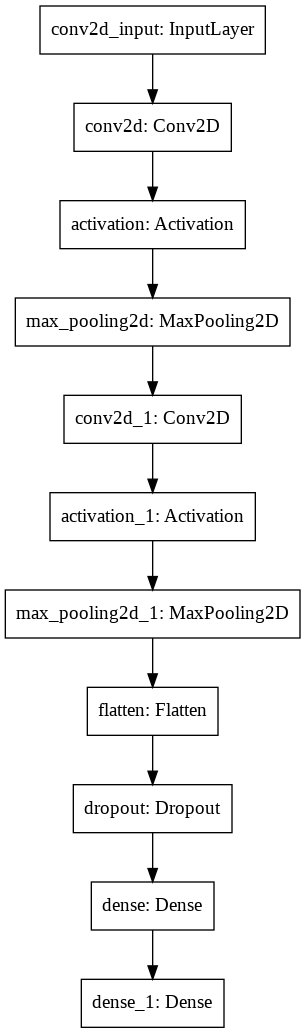

In [ ]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='face_mask_detection_flowchart.png')

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
fitted_model=model.fit(train_X,train_y,epochs=1000,validation_split=0.25, verbose=0, callbacks=[es, mc])


Epoch 00001: val_accuracy improved from -inf to 0.60721, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.60721 to 0.82766, saving model to best_model.h5

Epoch 00003: val_accuracy improved from 0.82766 to 0.84369, saving model to best_model.h5

Epoch 00004: val_accuracy improved from 0.84369 to 0.89178, saving model to best_model.h5

Epoch 00005: val_accuracy did not improve from 0.89178

Epoch 00006: val_accuracy improved from 0.89178 to 0.92585, saving model to best_model.h5

Epoch 00007: val_accuracy improved from 0.92585 to 0.93587, saving model to best_model.h5

Epoch 00008: val_accuracy did not improve from 0.93587

Epoch 00009: val_accuracy improved from 0.93587 to 0.93988, saving model to best_model.h5

Epoch 00010: val_accuracy did not improve from 0.93988

Epoch 00011: val_accuracy did not improve from 0.93988

Epoch 00012: val_accuracy did not improve from 0.93988

Epoch 00013: val_accuracy did not improve from 0.93988

Epoch 00014: val_accuracy did

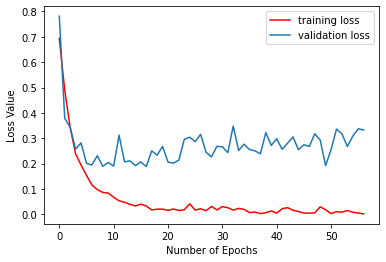

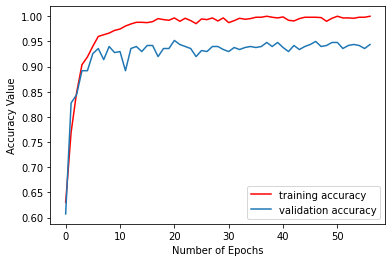

In [ ]:

from matplotlib import pyplot as plt
plt.plot(fitted_model.history['loss'],'r',label='training loss')
plt.plot(fitted_model.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

In [ ]:
layer_names = [] 

for layer in model.layers[:10]: 
  layer_names.append(layer.name) 
print(layer_names) 

['conv2d', 'activation', 'max_pooling2d', 'conv2d_1', 'activation_1', 'max_pooling2d_1', 'flatten', 'dropout', 'dense', 'dense_1']
